In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd

File = '/content/drive/MyDrive/Algoritmos/Datathon/Datos/IdentificacionSesgo - DataSet29.06.csv'
df = pd.read_csv(File, header = 0)

In [ ]:
df['GravedadMode'] = df['Gravedad'].str.split(',',expand=True).mode(axis=1, numeric_only=False, dropna=True)[0]


In [ ]:
df = df[['Item (Texto)', 'GravedadMode']]


In [ ]:
df.iloc[0]

Item (Texto)    Las protestas, sin precedentes, ya completan c...
GravedadMode                                                    2
Name: 0, dtype: object

In [ ]:
X = df['Item (Texto)'].values
y = df['GravedadMode'].values

In [ ]:
from tensorflow import keras
%tensorflow_version 2.x

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [ ]:
t = Tokenizer()
t.fit_on_texts(X)

In [ ]:
vocab_size = len(t.word_index) + 1
print(vocab_size) #número de palabras únicas

3209


In [ ]:
sequences = t.texts_to_sequences(X)

In [ ]:
print(X[2])
print(sequences[2])

Una patrullera de la Policía Nacional denunció este jueves que fue violada por vándalos en Cali, Valle del Cauca. La oficial se encontraba en labores de seguridad durante las manifestaciones del pasado 29 de abril cuando ocurrieron los hechos. Había sido asignada para brindar seguridad en un sector al oriente de Cali. En medio de los actos vandálicos, ella ingresó al CAI para protegerse. Pero los vándalos la emprendieron contra las instalaciones y lo prendieron fuego. Allí, esta mujer empezó a vivir los momentos más duros de su vida.
[14, 1137, 1, 2, 34, 20, 433, 30, 255, 3, 42, 1138, 12, 434, 5, 32, 110, 11, 101, 2, 435, 10, 654, 5, 1139, 1, 82, 53, 9, 111, 11, 74, 1140, 1, 102, 50, 436, 7, 51, 202, 54, 1141, 16, 1142, 82, 5, 13, 103, 18, 1143, 1, 32, 5, 104, 1, 7, 256, 437, 655, 1144, 18, 438, 16, 1145, 44, 7, 434, 2, 1146, 35, 9, 439, 6, 29, 1147, 143, 203, 83, 656, 1148, 8, 1149, 7, 315, 23, 1150, 1, 21, 84]


In [ ]:
def max_sequence():
    for i in range(1, len(sequences)):
        max_length = len(sequences[0])
        if len(sequences[i]) > max_length:
            max_length = len(sequences[i])
    return max_length

In [ ]:
maxlen = max_sequence()

maxlen

76

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_X = pad_sequences(sequences, padding='post', maxlen=maxlen)

In [ ]:
padded_X[0,:]

array([   9,   39,   33,  429,   67, 1100, 1101,   13,   81,   10,   25,
       1102,    1,  313,   12,  142,    1,    2,   88,    6,  126,   18,
       1103,    1,    2, 1104,    8,   73,    1,   57,    6,  251,    5,
          4,   26,   98,  430,    1,    9,  643,    1,    7,   37,   64,
        644,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [ ]:
from tensorflow.keras.utils import to_categorical
import numpy as np

labels = to_categorical(np.asarray(y))

In [ ]:
labels[:3]

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_X, labels, test_size = 0.25, random_state = 0)

In [ ]:
print('X_train size:', X_train.shape)
print('y_train size:', y_train.shape)
print('X_test size:', X_test.shape)
print('y_test size:', y_test.shape)

X_train size: (109, 76)
y_train size: (109, 4)
X_test size: (37, 76)
y_test size: (37, 4)


In [ ]:
keras.backend.clear_session()

In [ ]:
# aver

from keras.models import Sequential
from keras import layers
from tensorflow.keras.layers import LSTM

embedding_dim = 50

lstm_mod = Sequential()
lstm_mod.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
lstm_mod.add(LSTM(456, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lstm_mod.add(layers.Dense(4, activation='softmax'))
lstm_mod.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 76, 50)            160450    
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 456)               924768    
_________________________________________________________________
dense (Dense)                (None, 4)                 1828      
Total params: 1,087,046
Trainable params: 1,087,046
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Epoch 1/100
1/1 [==============================] - 14s 14s/step - loss: 1.3858 - acc: 0.3448 - val_loss: 1.3931 - val_acc: 0.2727
Epoch 2/100
1/1 [==============================] - 0s 338ms/step - loss: 1.3765 - acc: 0.3218 - val_loss: 1.4015 - val_acc: 0.2727
Epoch 3/100
1/1 [==============================] - 0s 344ms/step - loss: 1.3658 - acc: 0.3218 - val_loss: 1.4266 - val_acc: 0.2727
Epoch 4/100
1/1 [==============================] - 0s 364ms/step - loss: 1.3531 - acc: 0.3218 - val_loss: 1.5317 - val_acc: 0.2727
Epoch 5/100
1/1 [==============================] - 0s 347ms/step - loss: 1.3795 - acc: 0.3218 - val_loss: 1.4341 - val_acc: 0.2727
Epoch 6/100
1/1 [==============================] - 0s 324ms/step - loss: 1.3407 - acc: 0.3218 - val_loss: 1.4156 - val_acc: 0.2273
Epoch 7/100
1/1 [==============================] - 0s 336ms/step - loss: 1.3434 - acc: 0.5057 - val_loss: 1.4087 - val_acc: 0.1818
Epoch 8/100
1/1 [==============================] - 0s 379ms/step - loss: 1.3429 - ac

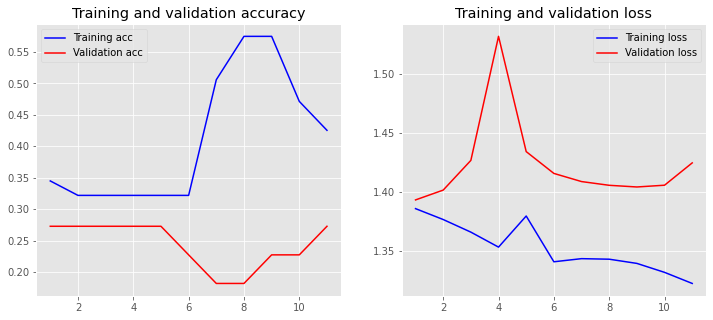

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping      


es=EarlyStopping(monitor='val_loss',patience=10)

history = lstm_mod.fit(X_train, y_train, epochs=100 , validation_split=0.2, batch_size=456, callbacks=[es])
loss, accuracy = lstm_mod.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
y_test[0]

array([0., 1., 0., 0.], dtype=float32)

In [ ]:
comentario = ['El presidente en alocución oficial pronunció un discurso de amor para toda la población, incitando a abrazar a todo aquel de la oposición y declarando que todas las posturas son válidas en el país.']

In [ ]:
comentario = t.texts_to_sequences(comentario)


In [ ]:
comentario = pad_sequences(comentario, padding = 'post',maxlen=maxlen)


In [ ]:
np.argmax(lstm_mod.predict(comentario), axis=-1)

array([2])

In [ ]:
X_train.shape[1]

76